# Sentiment Classification using TextBlob

## Introduction

TextBlob is a Python library for processing and analyzing text.

It’s built on top of NLTK and Pattern, and it provides an easy-to-use API for tasks like sentiment analysis, part-of-speech tagging, noun phrase extraction, and translation.

For sentiment, TextBlob returns two key values: polarity (ranging from –1 for negative to +1 for positive) and subjectivity (0 for objective to 1 for subjective).

It’s popular because it’s beginner-friendly yet powerful enough for quick natural language processing tasks.

## Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si
from yahoo_fin import options
from textblob import TextBlob
import seaborn as sns
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import datetime

## Selecting which stocks to follow

In [6]:
website_url = 'https://finviz.com/quote.ashx?t='
company_tikcers = ['AMD', 'AMZN', 'FB', 'GOOG']

## Creating a DataFrame with news headlines

In [7]:
news_tables = {}

for ticker in company_tikcers:
  url = website_url + ticker

  req = Request(url=url, headers={'user-agent': 'my-scrape'})
  response = urlopen(req)
  html = BeautifulSoup(response, 'html')
  news_data = html.find(id='news-table')
  news_tables[ticker] = news_data

In [8]:
parsed_data = []

for ticker, news_table in news_tables.items():
  for row in news_table.findAll('tr'):
    title = row.a.text
    date_data = row.td.text.split(' ')

    if len(date_data) == 1:
      time = date_data[0][0:7]
    else:
      date = datetime.datetime.strptime(date_data[0], '%b-%d-%y').strftime('%Y/%m/%d')
      time = date_data[1][0:7]

    parsed_data.append([ticker, date, time, title])

In [9]:
dataset = pd.DataFrame(parsed_data, columns=["Company", "Date", "Time", "News Headline"])
dataset.to_csv('CompanyNewsHeadlines_WithoutSentiment.csv', index=False)
dataset.head()

,Company,Date,Time,News Headline
0,AMD,2020/11/17,06:30AM,"Intel May Be Down, But It's Far From Being Out"
1,AMD,2020/11/16,08:02PM,Samsung Intensifies Chip Wars With Bet It Can ...
2,AMD,2020/11/16,04:15PM,AMD to Present at Credit Suisse 24th Annual Te...
3,AMD,2020/11/16,10:29AM,Microsoft (MSFT) Detects Cyberattacks on COVID...
4,AMD,2020/11/16,09:45AM,NVIDIA Looks to Erase a Key AMD Advantage


## Analysing the headlines using TextBlob

In [10]:
def textblob_analysis(news_headline):
  analysis = TextBlob(news_headline)
  return analysis.sentiment.polarity

In [11]:
# Giving a value in the TextBlob scale to each headline
dataset['Compound'] = dataset['News Headline'].apply(lambda headline: textblob_analysis(headline))

In [12]:
dataset.head()

,Company,Date,Time,News Headline,Compound
0,AMD,2020/11/17,06:30AM,"Intel May Be Down, But It's Far From Being Out",-0.027778
1,AMD,2020/11/16,08:02PM,Samsung Intensifies Chip Wars With Bet It Can ...,0.000000
2,AMD,2020/11/16,04:15PM,AMD to Present at Credit Suisse 24th Annual Te...,0.000000
3,AMD,2020/11/16,10:29AM,Microsoft (MSFT) Detects Cyberattacks on COVID...,0.000000
4,AMD,2020/11/16,09:45AM,NVIDIA Looks to Erase a Key AMD Advantage,0.000000


### Conclude (based on the TextBlob Value) the sentiment of the headline

In [13]:
def sentiment_declareation(sentiment_value):
  if -0.2 < sentiment_value <= 0.2:
      return 'neu'
  elif 0.2 < sentiment_value <= 1.0:
      return 'pos'
  elif -1.0 <= sentiment_value <= -0.2:
      return 'neg'

In [14]:
dataset['Sentiment'] = dataset['Compound'].apply(lambda value: sentiment_declareation(value))

In [15]:
dataset['Date'] = pd.to_datetime(dataset.Date).dt.date

In [16]:
dataset.head()

,Company,Date,Time,News Headline,Compound,Sentiment
0,AMD,2020-11-17,06:30AM,"Intel May Be Down, But It's Far From Being Out",-0.027778,neu
1,AMD,2020-11-16,08:02PM,Samsung Intensifies Chip Wars With Bet It Can ...,0.000000,neu
2,AMD,2020-11-16,04:15PM,AMD to Present at Credit Suisse 24th Annual Te...,0.000000,neu
3,AMD,2020-11-16,10:29AM,Microsoft (MSFT) Detects Cyberattacks on COVID...,0.000000,neu
4,AMD,2020-11-16,09:45AM,NVIDIA Looks to Erase a Key AMD Advantage,0.000000,neu


In [17]:
dataset.to_csv('CompanyNewsHeadlines.csv', index=False)

## Selecting the timeframe where we consider our sentiment insights can be applied (for each stock)

In [18]:
max_min_date = dataset.groupby(['Company']).agg({'Date': [np.min,np.max]})
max_min_date

Date            
               amin        amax
Company                        
AMD      2020-10-27  2020-11-17
AMZN     2020-11-12  2020-11-17
FB       2020-11-06  2020-11-17
GOOG     2020-11-10  2020-11-17

In [19]:
dataset['MaxDate'] = dataset.groupby('Company').Date.transform('max')
dataset['MinDate'] = dataset.groupby('Company').Date.transform('min')

dataset.head()

,Company,Date,Time,News Headline,Compound,Sentiment,MaxDate,MinDate
0,AMD,2020-11-17,06:30AM,"Intel May Be Down, But It's Far From Being Out",-0.027778,neu,2020-11-17,2020-10-27
1,AMD,2020-11-16,08:02PM,Samsung Intensifies Chip Wars With Bet It Can ...,0.000000,neu,2020-11-17,2020-10-27
2,AMD,2020-11-16,04:15PM,AMD to Present at Credit Suisse 24th Annual Te...,0.000000,neu,2020-11-17,2020-10-27
3,AMD,2020-11-16,10:29AM,Microsoft (MSFT) Detects Cyberattacks on COVID...,0.000000,neu,2020-11-17,2020-10-27
4,AMD,2020-11-16,09:45AM,NVIDIA Looks to Erase a Key AMD Advantage,0.000000,neu,2020-11-17,2020-10-27


In [20]:
company_early_late_dates = {}

for index, row in dataset.iterrows():
  if row['Company'] in company_early_late_dates:
      company_early_late_dates[row['Company']]['early'] = row['MinDate']
      company_early_late_dates[row['Company']]['late'] = row['MaxDate']
  else:
    company_early_late_dates[row['Company']] = {'early': None, 'late': None}

company_early_late_dates

{'AMD': {'early': datetime.date(2020, 10, 27),
  'late': datetime.date(2020, 11, 17)},
 'AMZN': {'early': datetime.date(2020, 11, 12),
  'late': datetime.date(2020, 11, 17)},
 'FB': {'early': datetime.date(2020, 11, 6),
  'late': datetime.date(2020, 11, 17)},
 'GOOG': {'early': datetime.date(2020, 11, 10),
  'late': datetime.date(2020, 11, 17)}}

In [21]:
for key, value in company_early_late_dates.items():
  print(key, '->', value)
  tmp_df = si.get_data(key, start_date=value['early'], end_date=value['late'])
  tmp_df['date'] = tmp_df.index
  tmp_df.to_csv(key + '_TextBlob.csv', index=False)

AMD -> {'early': datetime.date(2020, 10, 27), 'late': datetime.date(2020, 11, 17)}
AMZN -> {'early': datetime.date(2020, 11, 12), 'late': datetime.date(2020, 11, 17)}
FB -> {'early': datetime.date(2020, 11, 6), 'late': datetime.date(2020, 11, 17)}
GOOG -> {'early': datetime.date(2020, 11, 10), 'late': datetime.date(2020, 11, 17)}


### Count the resulting number of positive, neutral and negative sentiment classifications

In [22]:
sentiment_result = {}
for value in dataset['Sentiment']:
  if value in sentiment_result:
    if value == 'neu':
      sentiment_result['neu'] += 1
    elif value == 'pos':
      sentiment_result['pos'] += 1
    elif value == 'neg':
      sentiment_result['neg'] += 1
  else:
    sentiment_result[value] = 1

sentiment_result

{'neg': 19, 'neu': 301, 'pos': 80}

### Represent the positive-neutral-negative sentiment classifications by company

In [23]:
result_by_companies = {}
for index, row in dataset.iterrows():
  if row['Company'] in result_by_companies:
    if row['Sentiment'] == 'neu':
      result_by_companies[row['Company']]['neu'] +=1
    if row['Sentiment'] == 'pos':
      result_by_companies[row['Company']]['pos'] +=1
    if row['Sentiment'] == 'neg':
      result_by_companies[row['Company']]['neg'] +=1
  else:
    result_by_companies[row['Company']] = {'neg': 0, 'neu': 0, 'pos': 0}

result_by_companies

{'AMD': {'neg': 5, 'neu': 63, 'pos': 31},
 'AMZN': {'neg': 4, 'neu': 75, 'pos': 20},
 'FB': {'neg': 5, 'neu': 82, 'pos': 12},
 'GOOG': {'neg': 5, 'neu': 78, 'pos': 16}}

In [24]:
dataframe_list = []
for key, value in result_by_companies.items():
  print(key, '->', value)
  dataframe_list.append([key, value['neg'], value['neu'], value['pos']])


dataset_company = pd.DataFrame(dataframe_list, columns=["Company", "Neg", "Neu", "Pos"])
dataset_company.head()

AMD -> {'neg': 5, 'neu': 63, 'pos': 31}
AMZN -> {'neg': 4, 'neu': 75, 'pos': 20}
FB -> {'neg': 5, 'neu': 82, 'pos': 12}
GOOG -> {'neg': 5, 'neu': 78, 'pos': 16}


,Company,Neg,Neu,Pos
0,AMD,5,63,31
1,AMZN,4,75,20
2,FB,5,82,12
3,GOOG,5,78,16


## Bar Graph

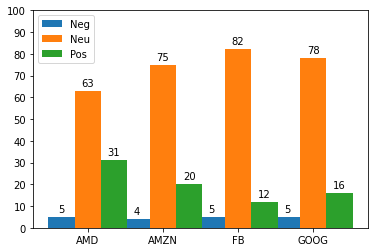

In [25]:
index = np.arange(len(company_tikcers))
score_label = np.arange(0, 110, 10)

bar_width = 0.35

fig, ax = plt.subplots()
barNeg = ax.bar(index - bar_width, dataset_company['Neg'], bar_width, label='Neg')
barNeu = ax.bar(index, dataset_company['Neu'], bar_width, label='Neu')
barPos = ax.bar(index + bar_width, dataset_company['Pos'], bar_width, label='Pos')

ax.set_xticks(index)
ax.set_xticklabels(company_tikcers)

ax.set_yticks(score_label)
ax.set_yticklabels(score_label)


ax.legend()

def insert_data_labels(bars):
  for bar in bars:
    bar_height = bar.get_height()
    ax.annotate('{0:.0f}'.format(bar.get_height()),
                xy=(bar.get_x() + bar.get_width() / 2, bar_height),
                xytext=(0,3),
                textcoords='offset points',
                ha='center',
                va='bottom'
    )

insert_data_labels(barNeg)
insert_data_labels(barNeu)
insert_data_labels(barPos)

plt.show()

## Average sentiment by company

In [26]:
mean_df = dataset.groupby(['Company', 'Date']).mean()

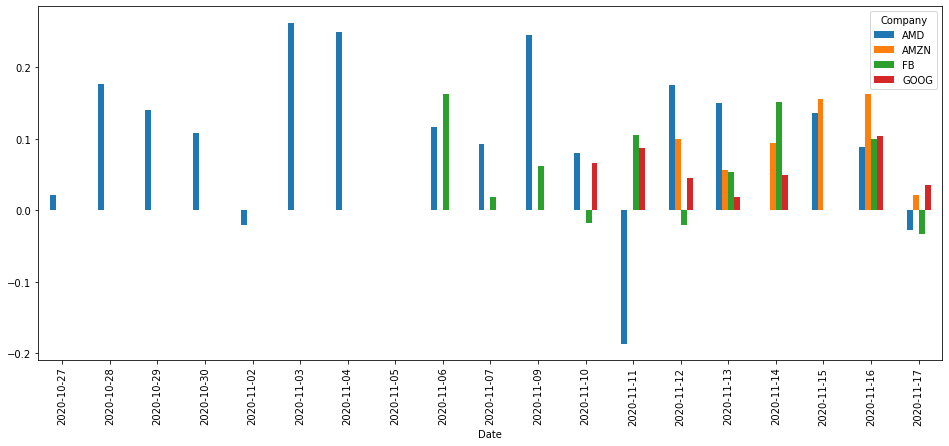

In [27]:
mean_df = mean_df.unstack()
mean_df = mean_df.xs('Compound', axis='columns').transpose()
mean_df.plot(kind='bar', figsize=(16.2, 6.5))

## Pie Chart

In [28]:
def percentage(part, whole):
  temp = 100 * float(part) / float(whole)
  return format(temp, '.2f')

In [29]:
def visualization(positive, neutral, negative):
  labels = ['Positive [' + str(positive) + '%]','Neutral [' + str(neutral) + '%]',
            'Negative [' + str(negative) + '%]']
  sizes = [positive, neutral, negative]
  colors = ['lightgreen', 'gold', 'red']
  patches, texts = plt.pie(sizes, colors=colors, startangle=90)
  plt.title('Aggregate sentiment value of the economic news headlines')
  plt.legend(patches, labels, loc="best")
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

In [30]:
def company_specific_sentiment_visualization(company_name):
  company_df = dataset[dataset['Company'] == company_name]
  temp = company_df.groupby(['Company', 'Date']).mean()
  temp= temp.unstack()
  temp = temp.xs('Compound', axis='columns').transpose()
  temp.plot(kind='line', figsize=(16.2, 6.5))

In [31]:
def company_specific_sentiment_and_stockclose_day_focus_visualization(company_name, company_stock_dataframe):
  company_specific = dataset[dataset['Company'] == company_name]
  temp_company = company_specific.groupby(['Company', 'Date']).mean()
  temp_company.to_csv(company_name + '_SentimentAndValueOnDays.csv')

  temp_dataframe = pd.read_csv("/content/" + company_name + "_SentimentAndValueOnDays.csv")
  temp_dataframe['adjclose'] = temp_dataframe.Date.map(company_stock_dataframe.set_index('date')['adjclose'].to_dict())
  temp_dataframe = temp_dataframe.dropna(subset=['adjclose'])
  return temp_dataframe

In [32]:
def company_compound_adjclose_normalized(company_name, company_combinated_dataframe):
  normalized_df=(company_combinated_dataframe-company_combinated_dataframe.mean())/company_combinated_dataframe.std()

  plt.figure(figsize=(16.2, 6.5))
  plt.title(company_name + ': Normalized AdjClose values with Compounds')
  plt.plot(company_combinated_dataframe['Date'], normalized_df['Compound'], label='compound')
  plt.plot(company_combinated_dataframe['Date'], normalized_df['adjclose'], label='adjclose')
  plt.xticks(rotation=70)
  plt.xlabel('Date')
  plt.ylabel('Compound')
  plt.legend()
  plt.show()

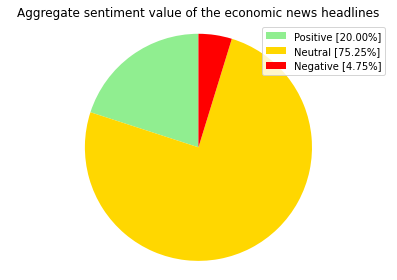

In [33]:
all_num = sentiment_result['pos'] + sentiment_result['neu'] + sentiment_result['neg']
pos_percent = percentage(part=sentiment_result['pos'], whole=all_num)
neu_percent = percentage(part=sentiment_result['neu'], whole=all_num)
neg_percent = percentage(part=sentiment_result['neg'], whole=all_num)

visualization(positive=pos_percent,neutral=neu_percent, negative=neg_percent)